In [1]:
import pandas as pd
import locale
import glob
import chardet
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data

In [23]:
def read_data_per_file(file: str) -> pd.DataFrame:
    """
    Reads data from a CSV file and returns it as a pandas DataFrame. Handles skipping rows

    Args:
        file (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The DataFrame containing the data from the CSV file.
    """
    # Detect the encoding
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
        encoding = result['encoding']
    data =  pd.read_csv(file, encoding=encoding, skiprows=2)
        
    return data

In [24]:
def load_visitor_counts_data(
    data_folder: str,
) -> pd.DataFrame:
    """
    Loads visitor counts data from multiple CSV files in the specified folder and deletes some unnecessary column.

    Args:
        data_folder (str): The path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: The DataFrame containing the visitor counts data.
    """
    # Read data from CSV files

    raw_visitor_counts = pd.concat([read_data_per_file(
        file
    ) for file in glob.glob(f"{data_folder}/*.csv")])
    
    # Drop last empty column
    visitor_counts = raw_visitor_counts.drop(columns=["Unnamed: 96"])

    return visitor_counts

visitor_counts = load_visitor_counts_data(data_folder="data/visitor_counts")

# Preprocess data

In [25]:
# Check the data type of the 'Time' column
print(visitor_counts['Time'].dtype)

object


In [26]:
# Convert the 'Time' column to string if it's not already
visitor_counts['Time'] = visitor_counts['Time'].astype(str)

In [27]:
def parse_german_dates(
    df: pd.DataFrame,
    date_column_name: str
) -> pd.DataFrame:
    """
    Parses German dates in the specified date column of the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the date column.
        date_column_name (str): The name of the date column.

    Returns:
        pd.DataFrame: The DataFrame with parsed German dates.
    """
    
    # Set German locale
    locale.setlocale(locale.LC_TIME, "de_DE.UTF-8")
    
    # Mapping of German month names to their English equivalents
    month_map = {
        "Jan.": "Jan",
        "Feb.": "Feb",
        "März": "Mar",
        "Apr.": "Apr",
        "Mai": "May",
        "Juni": "Jun",
        "Juli": "Jul",
        "Aug.": "Aug",
        "Sep.": "Sep",
        "Okt.": "Oct",
        "Nov.": "Nov",
        "Dez.": "Dec"
    }

    # Replace German month names with English equivalents
    for german, english in month_map.items():
        df[date_column_name] = df[date_column_name].str.replace(german, english)

    # Parse the dates
    df[date_column_name] = pd.to_datetime(df[date_column_name], format="mixed")

         # Set the date column as the index
    df.set_index(date_column_name, inplace=True)

    return df

visitor_counts_parsed_dates = parse_german_dates(df=visitor_counts, date_column_name="Time")

# Saving the Aggregated DataFrame to CSV

In [28]:
visitor_counts_parsed_dates.columns[-1]

'Wistlberg Fußgänger OUT'

In [29]:
# Define the folder path
folder_path = "data/visitor_count"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")

In [30]:
# Define the full path to save the CSV file in the 'visitor_count' subfolder
output_path = os.path.join(folder_path, "aggregated_historic_visitor_count.csv")

# Save the aggregated and parsed data to the specified CSV file
visitor_counts_parsed_dates.to_csv(output_path, sep=',', encoding='utf-8', index=True)

# Print a confirmation message
print(f"Data saved to '{output_path}'")

Data saved to 'data/visitor_count\aggregated_historic_visitor_count.csv'


## Data Exploration


In [31]:
visitor_counts = visitor_counts_parsed_dates

In [32]:
# Checking if there are any missing values in the index
missing_index = visitor_counts.index.isnull().sum()
print(f"Number of missing values in the index: {missing_index}")

# Check for missing values (NaT) in the index
missing_in_index = visitor_counts.index.isna().sum()

print(f"Missing (NaT) values in the index: {missing_in_index}")

Number of missing values in the index: 0
Missing (NaT) values in the index: 0


Exploratory Data Analysis 

## Resample the Data by Year

In [33]:
# Resample the data to yearly frequency and sum the counts
yearly_data = visitor_counts.resample('Y').sum()

### Calculate Yearly Totals

In [34]:
# Calculate the total visitors per year across all sensors
yearly_data['Total_Visitors'] = yearly_data.sum(axis=1)

# Display the yearly total visitors
print(yearly_data['Total_Visitors'])


Time
2017-12-31     557293.0
2018-12-31     585362.0
2019-12-31     711168.0
2020-12-31     926212.0
2021-12-31     985854.0
2022-12-31    1218797.0
2023-12-31    1618783.0
Freq: A-DEC, Name: Total_Visitors, dtype: float64


### Visualize Yearly Trends

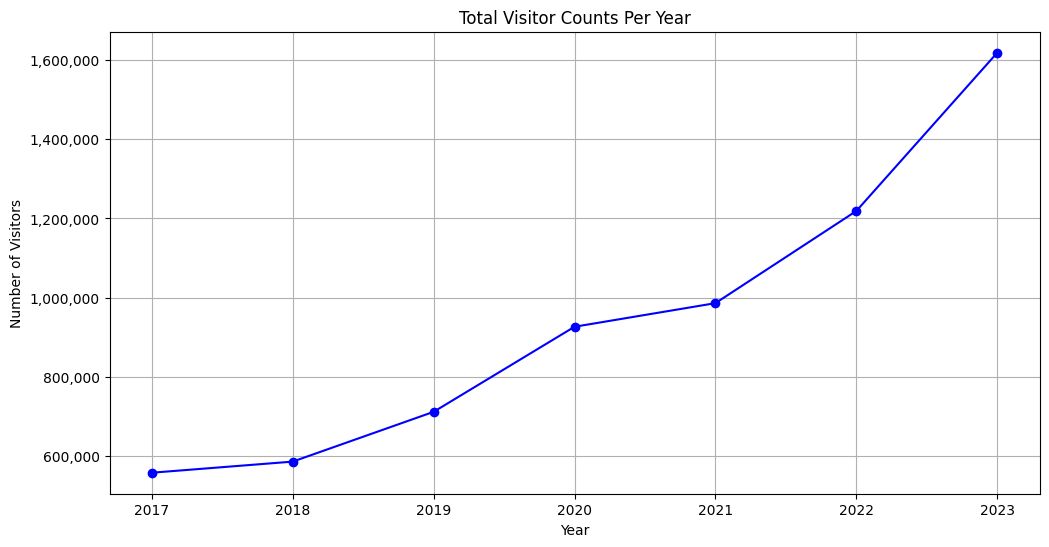

In [35]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define a function to format the y-axis labels
def format_thousands(x, pos):
    'The two args are the value and tick position'
    return f'{int(x):,}'

# Plot the total visitors per year
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index.year, yearly_data['Total_Visitors'], marker='o', linestyle='-', color='b')

# Set title and labels
plt.title('Total Visitor Counts Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Visitors')

# Format the y-axis with thousands separator
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_thousands))

# Ensure all years are shown on x-axis
plt.xticks(yearly_data.index.year)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


### Analyze Yearly Growth Rates

Time
2017-12-31          NaN
2018-12-31     5.036668
2019-12-31    21.492000
2020-12-31    30.238143
2021-12-31     6.439346
2022-12-31    23.628549
2023-12-31    32.818099
Freq: A-DEC, Name: Yearly_Growth_Rate, dtype: float64


posx and posy should be finite values
posx and posy should be finite values


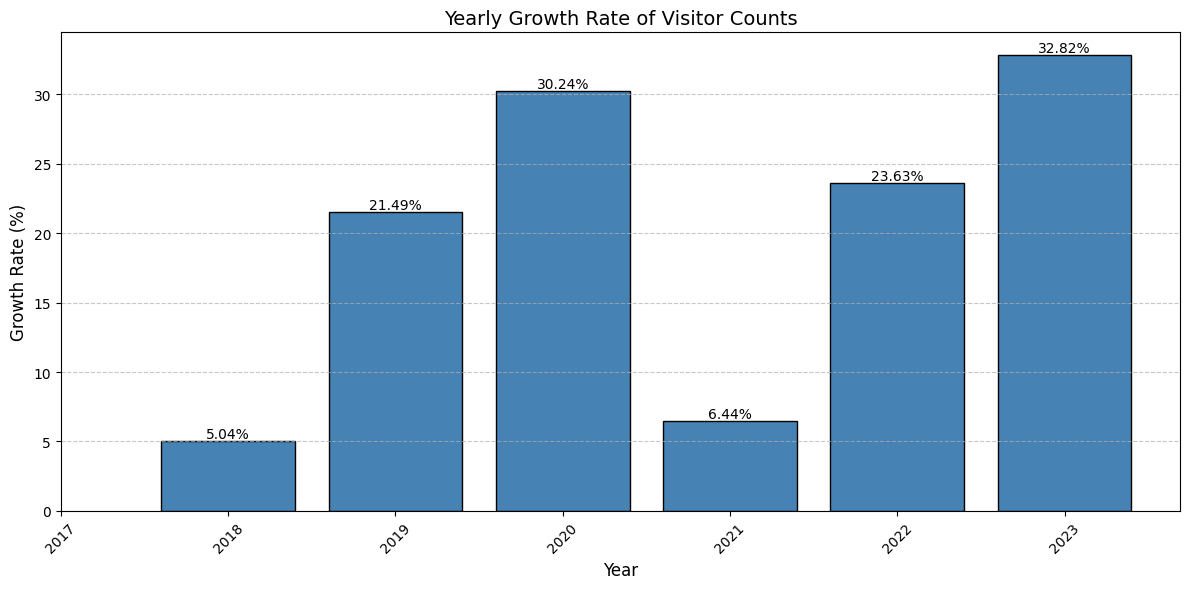

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the year-over-year percentage change
yearly_data['Yearly_Growth_Rate'] = yearly_data['Total_Visitors'].pct_change() * 100

# Display the growth rates (for verification)
print(yearly_data['Yearly_Growth_Rate'])

# Plot the growth rates
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_data.index.year, yearly_data['Yearly_Growth_Rate'], color='steelblue', edgecolor='black')

# Add annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, color='black')

# Customize the plot
plt.title('Yearly Growth Rate of Visitor Counts', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_data.index.year, rotation=45)  # Rotate x-ticks for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Suppress FutureWarning
pd.options.mode.chained_assignment = None


## Monthly Trends

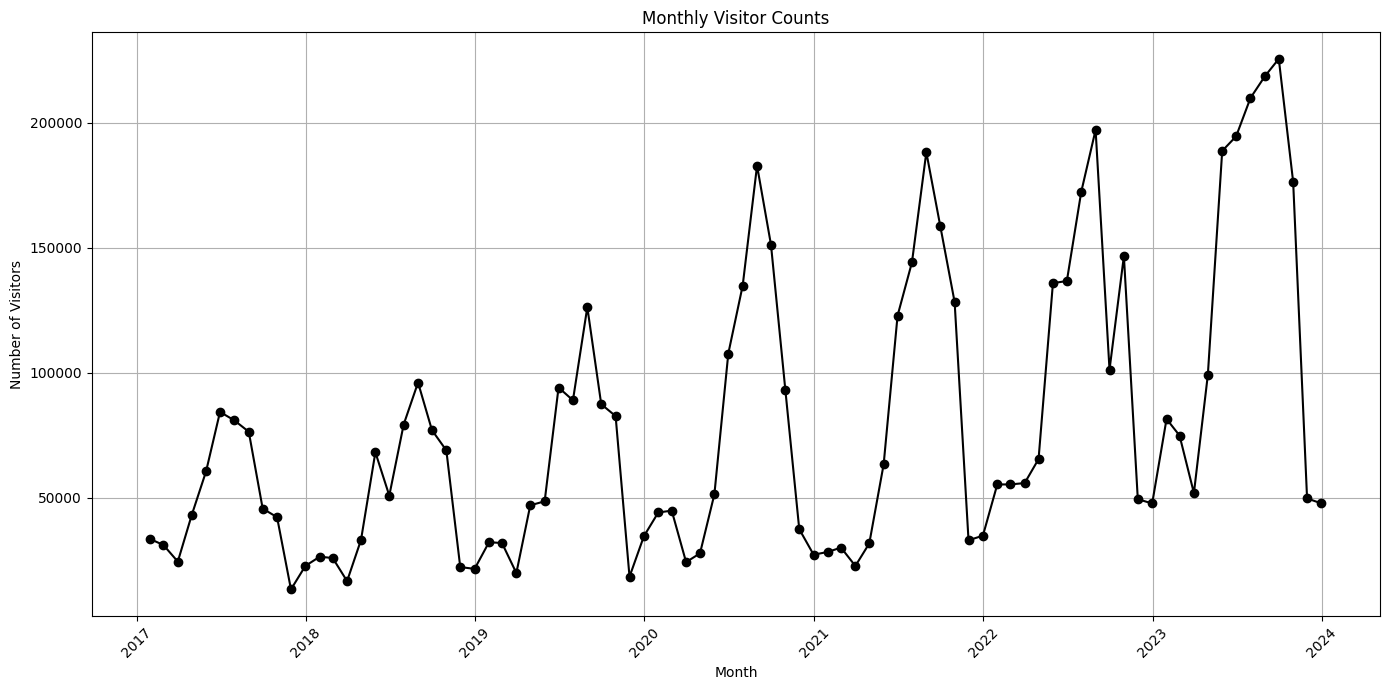

In [37]:
# Resample the data to a monthly frequency and sum the counts
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

# Calculate monthly totals
monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Plot monthly trends
plt.figure(figsize=(14, 7))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], marker='o', linestyle='-', color='black')
plt.title('Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Number of Visitors')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


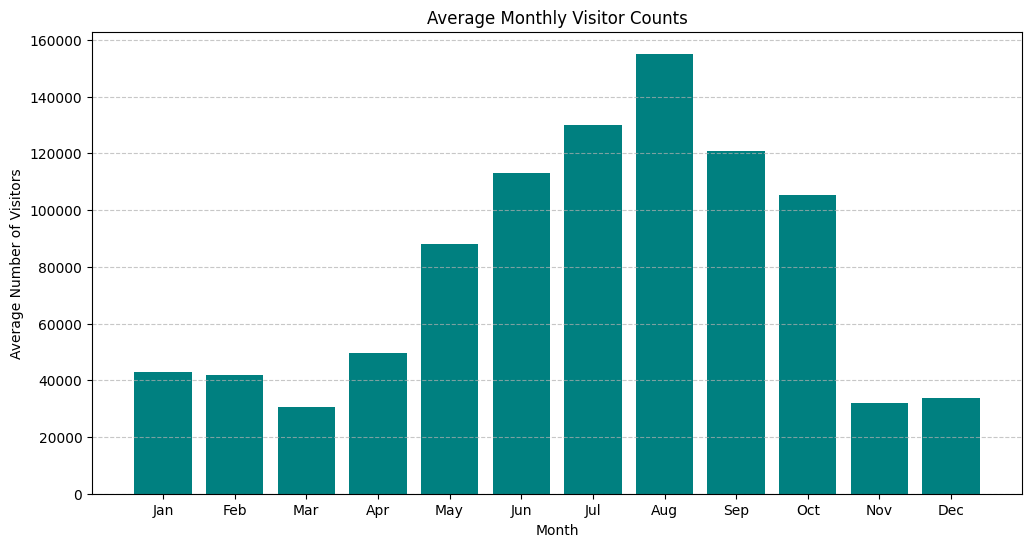

In [38]:
# Aggregate monthly data by year to find seasonal patterns
seasonal_data = monthly_data.groupby(monthly_data.index.month).mean()

# Plot average monthly visitor counts
plt.figure(figsize=(12, 6))
plt.bar(seasonal_data.index, seasonal_data['Total_Visitors'], color='teal')
plt.title('Average Monthly Visitor Counts')
plt.xlabel('Month')
plt.ylabel('Average Number of Visitors')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Seasonal decomposition of historic sensor data 

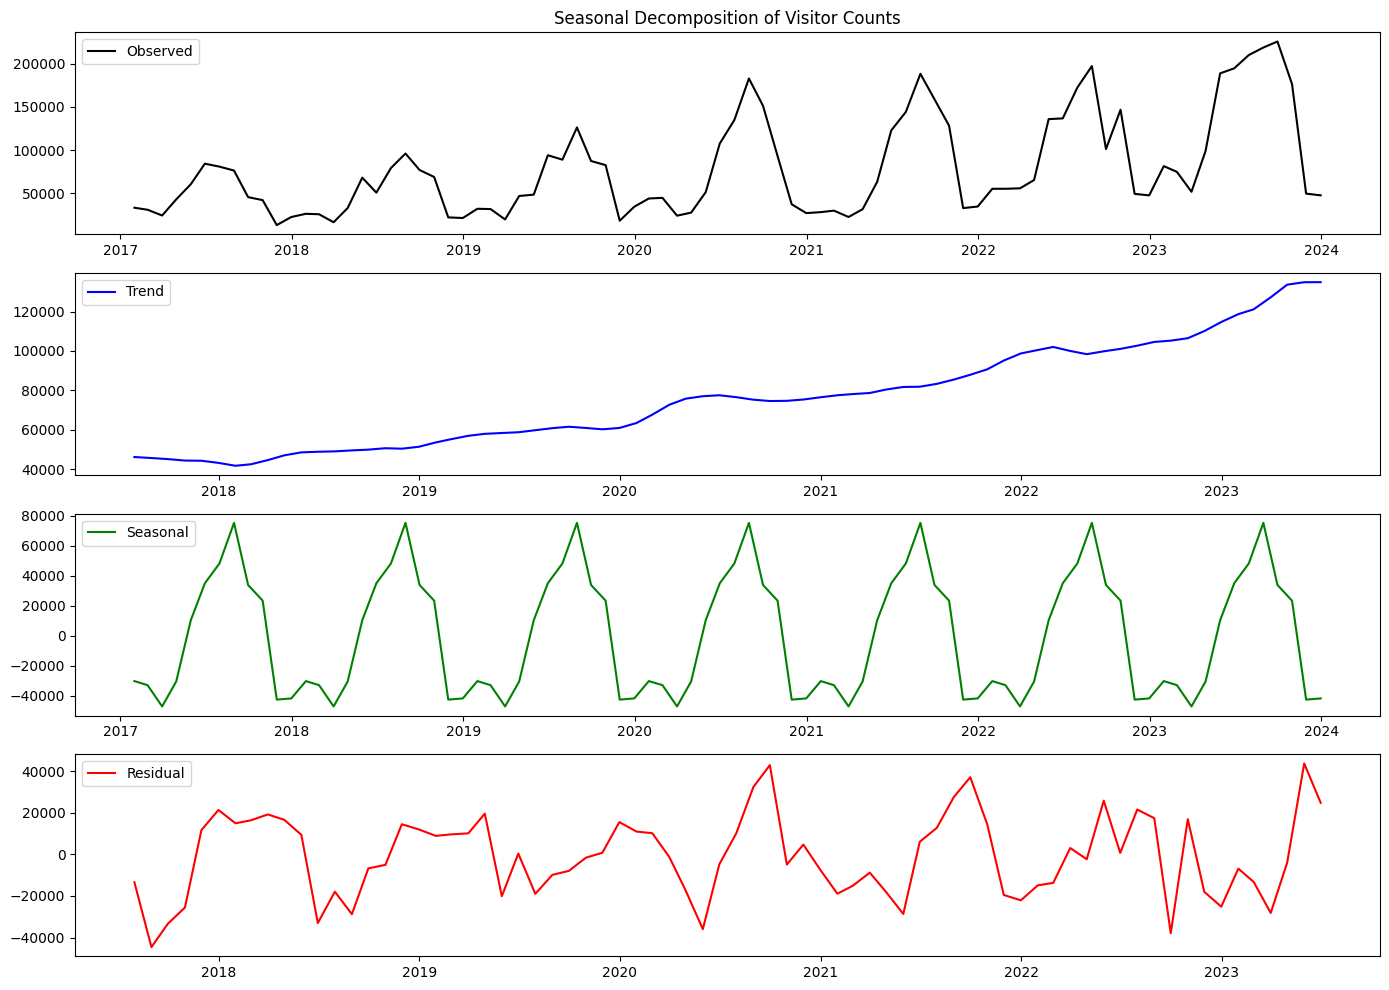

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(monthly_data['Total_Visitors'], model='additive')

# Plot the decomposition components
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, label='Observed', color='black')
plt.legend()
plt.title('Seasonal Decomposition of Visitor Counts')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual', color='red')
plt.legend()

plt.tight_layout()
plt.show()
    

Summary of the above stat:

Observed: Your raw visitor data.

Trend: Long-term direction in visitor counts.

Seasonal: Periodic fluctuations or seasonal patterns.

Residual: Random noise or irregular deviations

## Forecasting and Predictive Analysis

SARIMA Model for Visitor Count Forecasting


The Seasonal ARIMA (SARIMA) model is an extension of the ARIMA model used for time series forecasting, particularly effective for data with seasonal patterns. In our case, where visitor counts show trends and seasonal variations (e.g., more visitors in summer), SARIMA helps us capture both the overall trend and the seasonality.

Implementation:

Data Preparation: Resampled the data to monthly totals to focus on seasonal trends.

Model Definition: Specified SARIMA parameters that reflect both the short-term and seasonal dependencies in the data.

Model Fitting: The model is trained on historical data to understand underlying patterns.

Forecasting: The trained model is used to predict future visitor counts, giving insights into expected trends.

In [40]:
monthly_data = visitor_counts_parsed_dates.resample('M').sum()

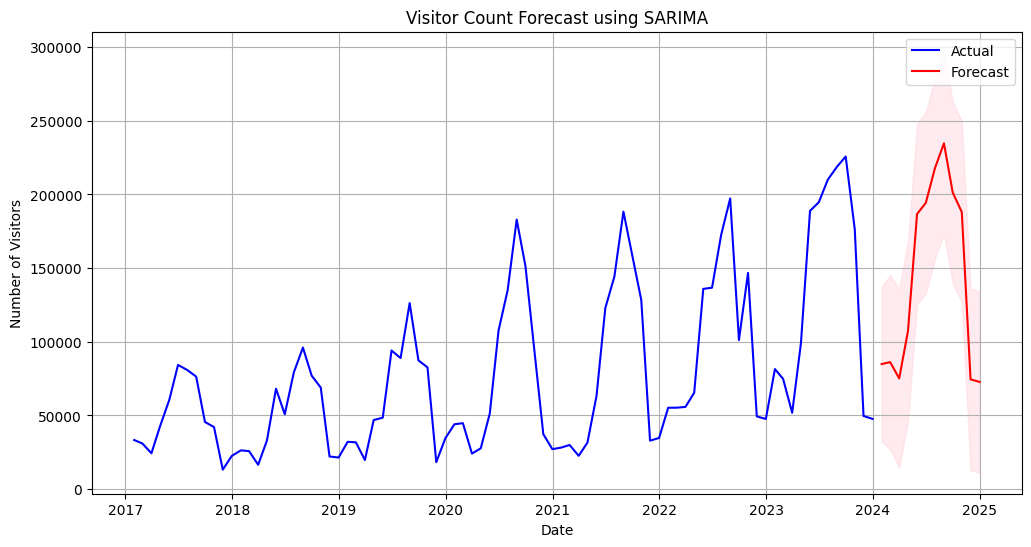

In [41]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Check if 'Total_Visitors' needs to be created by summing across all columns
if 'Total_Visitors' not in monthly_data.columns:
    monthly_data['Total_Visitors'] = monthly_data.sum(axis=1)

# Convert 'Total_Visitors' to numeric, forcing any non-numeric values to NaN
monthly_data['Total_Visitors'] = pd.to_numeric(monthly_data['Total_Visitors'], errors='coerce')

# Drop any rows with NaN values that might have been created during conversion
monthly_data.dropna(subset=['Total_Visitors'], inplace=True)

# Ensure the index is a DateTimeIndex with a frequency set
monthly_data.index = pd.to_datetime(monthly_data.index)
monthly_data = monthly_data.asfreq('M')

# Define the SARIMA model
model = SARIMAX(monthly_data['Total_Visitors'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12))

# Fit the model
model_fit = model.fit()

# Forecast the next 12 months
forecast = model_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_data.index[-1], periods=13, freq='M')[1:]
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the actual data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_data.index, monthly_data['Total_Visitors'], label='Actual', color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_series.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('Visitor Count Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.legend()
plt.grid(True)
plt.show()
